In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from datetime import datetime
import os
from scipy.io import savemat
import scipy.stats as stat


# Settings

## Path settings

In [2]:
save_path = 'results'
load_path = os.path.join('..', 'data', 'raw-timeseries')
ch_file_path = os.path.join(load_path, 'timeseries_10k_churners_of_20210109_from_20201226_to_20210116.csv')
no_file_path = os.path.join(load_path, 'timeseries_10k_non-churners_of_20210109_from_20201226_to_20210116.csv')

origin_dt = datetime.strptime('20201226 00:00:00', '%Y%m%d %H:%M:%S')

# Distribution functions

In [3]:
def poisson(k, lamb):
    return lamb**(k)*np.exp(-lamb)/np.math.factorial(k)

def cdf_poisson(k, lamb):
    cdf = 0
    for k_i in range(k+1):
        cdf += poisson(k_i, lamb)
    return cdf

def fit_poisson(x):
    n = x.shape[0]
    lamb = np.sum(x)/n
    return lamb

def eq_point_of_poissons(lamb_1, lamb_2):
    return (lamb_2 - lamb_1)/np.log(lamb_2/lamb_1)
        

# Load data

## Loader functions

In [4]:
def from_origin_to_hours(row):
    record_date = row['RECORD_DATE']
    return (record_date - origin_dt).total_seconds()/3600

def load_and_convert_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['RECORD_DATE'], infer_datetime_format=True)
    df['t'] = df.apply(from_origin_to_hours, axis=1)
    return df

## Load files

In [5]:
ch_df = load_and_convert_data(ch_file_path)
ch_df.tail(3)

,MSISDN,CALL_PARTNER,CALL_DURATION,CDR_TYPE,RECORD_DATE,t
0,989907869153,989014017231,62.0,2,2020-12-26 14:11:10,14.186111
1,989907869153,989014017231,31.0,2,2020-12-26 18:11:46,18.196111
2,989907869153,HAMRAH AVAL,0.0,4,2020-12-27 20:24:10,44.402778


In [6]:
no_df = load_and_convert_data(no_file_path)
no_df.tail(3)

,MSISDN,CALL_PARTNER,CALL_DURATION,CDR_TYPE,RECORD_DATE,t
9953293,989138974045,988968,0.0,4,2021-01-15 19:41:41,499.694722
9953294,989138974045,988968,0.0,4,2021-01-15 19:42:00,499.700000
9953295,989138974045,989179721374,145.0,1,2021-01-15 17:26:51,497.447500


# Settings

In [70]:
settings = {}
settings['cdrtype'] = 1
settings['diffh'] = 9
settings['method'] = 'multiparametric'
day_in_h = 24
hours = np.arange(0, day_in_h, settings['diffh'])
n_day = 7*3

def sett2str(sett):
    sett_str = ''
    for key, value in sett.items():
        sett_str += '%s%s_' % (key, value)
    return sett_str[:-1]

# Conversion functions

In [71]:
col_name = 'n_day%d_from%.1f_to%.1f'

def bin_records(df, n_day, hours, cdr_type):
    cdr_type_mask = (df['CDR_TYPE'] == cdr_type)
    
    users_n_df = df[['MSISDN', 't']].groupby(
        by=['MSISDN'],
        as_index=False,
        dropna=True,
        sort=False).count()['MSISDN']
    
    for day in range(n_day):
        for i_h, from_h in enumerate(hours[:-1]):
            to_h = hours[i_h + 1]
            
            # Define masks
            interval_mask =  (df['t'] >= (day*day_in_h + from_h)) & (df['t'] < (day*day_in_h + to_h))
            
            # Extract data
            partial_df = df[interval_mask & cdr_type_mask]
            
            # Bin the partial data
            partial_users_n_df = partial_df[['MSISDN', 't']].groupby(
                by=['MSISDN'],
                as_index=False,
                dropna=True,
                sort=False).count().rename(columns={'t': col_name % (day, from_h, to_h)})

            users_n_df = pd.merge(users_n_df, partial_users_n_df, how='left', on=['MSISDN'])

    users_n_df[users_n_df.isnull()] = 0
    
    return users_n_df


def convert_to_binary_parametric(ch_users_n_df, no_users_n_df):
    n_user = ch_users_n_df.shape[0] + no_users_n_df.shape[0]
    n_bin = ch_users_n_df.shape[1] - 1
    
    assert n_bin == (no_users_n_df.shape[1] - 1)
    
    is_ch_mat = np.zeros((n_user, n_bin))
    
    for i_bin in range(n_bin):
        ch_n = ch_users_n_df.iloc[:, i_bin + 1].to_numpy()
        no_n = no_users_n_df.iloc[:, i_bin + 1].to_numpy()

        ch_lamb = fit_poisson(ch_n)
        no_lamb = fit_poisson(no_n)

        k_eq = eq_point_of_poissons(ch_lamb, no_lamb)

        tot_n = np.concatenate((ch_n, no_n), axis=0)
        
        tot_binary = tot_n < k_eq

        is_ch_mat[:, i_bin] = tot_binary
        
    return is_ch_mat


def convert_to_2d_parametric(ch_users_n_df, no_users_n_df):
    n_user = ch_users_n_df.shape[0] + no_users_n_df.shape[0]
    n_bin = ch_users_n_df.shape[1] - 1
    
    assert n_bin == (no_users_n_df.shape[1] - 1)
    
    prob_mat = np.zeros((n_user, n_bin, 2))
    
    for i_bin in range(n_bin):
        ch_n = ch_users_n_df.iloc[:, i_bin + 1].to_numpy()
        no_n = no_users_n_df.iloc[:, i_bin + 1].to_numpy()
        
        tot_n = np.concatenate((ch_n, no_n), axis=0)

        ch_lamb = fit_poisson(ch_n)
        no_lamb = fit_poisson(no_n)
        
        n_user = tot_n.shape[0]
        for i_user in range(n_user):
            if tot_n[i_user] > 100:
                prob_mat[i_user, i_bin, 0] = 0
                prob_mat[i_user, i_bin, 1] = 0
                continue
                
            prob_mat[i_user, i_bin, 0] = poisson(tot_n[i_user], ch_lamb)
            prob_mat[i_user, i_bin, 1] = poisson(tot_n[i_user], no_lamb)
        
    return prob_mat


def convert_to_zscore(ch_users_n_df, no_users_n_df):
    n_user = ch_users_n_df.shape[0] + no_users_n_df.shape[0]
    n_bin = ch_users_n_df.shape[1] - 1
    
    assert n_bin == (no_users_n_df.shape[1] - 1)
    
    is_no_mat = np.zeros((n_user, n_bin))
        
    for i_bin in range(n_bin):
        ch_n = ch_users_n_df.iloc[:, i_bin + 1].to_numpy()
        no_n = no_users_n_df.iloc[:, i_bin + 1].to_numpy()
        
        tot_n = np.concatenate((ch_n, no_n), axis=0)

        ch_lamb = fit_poisson(ch_n)
        no_lamb = fit_poisson(no_n)
        
        k_eq = eq_point_of_poissons(ch_lamb, no_lamb)
        
        n_user = tot_n.shape[0]
        max_val = stat.norm.ppf(cdf_poisson(4*int(ch_lamb), ch_lamb))
        
        for i_user in range(n_user):
            if tot_n[i_user] > 4*ch_lamb:
                is_no_mat[i_user, i_bin] = max_val 
                continue
                
            if tot_n[i_user] > k_eq:
                is_no_mat[i_user, i_bin] = stat.norm.ppf(cdf_poisson(tot_n[i_user].astype(int), ch_lamb))
            else:
                is_no_mat[i_user, i_bin] = stat.norm.ppf(cdf_poisson(tot_n[i_user].astype(int), no_lamb))
        
    return -is_no_mat

# Convert dataframes

In [72]:
ch_users_n_df = bin_records(ch_df, n_day=n_day, hours=hours, cdr_type=settings['cdrtype'])

print(ch_users_n_df.shape)
ch_users_n_df.head(3)

(10000, 43)


,MSISDN,n_day0_from0.0_to9.0,n_day0_from9.0_to18.0,n_day1_from0.0_to9.0,n_day1_from9.0_to18.0,n_day2_from0.0_to9.0,n_day2_from9.0_to18.0,n_day3_from0.0_to9.0,n_day3_from9.0_to18.0,n_day4_from0.0_to9.0,...,n_day16_from0.0_to9.0,n_day16_from9.0_to18.0,n_day17_from0.0_to9.0,n_day17_from9.0_to18.0,n_day18_from0.0_to9.0,n_day18_from9.0_to18.0,n_day19_from0.0_to9.0,n_day19_from9.0_to18.0,n_day20_from0.0_to9.0,n_day20_from9.0_to18.0
0,989907869153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,4.0
1,989907711995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,989198416906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0


In [73]:
no_users_n_df = bin_records(no_df, n_day=n_day, hours=hours, cdr_type=settings['cdrtype'])

print(no_users_n_df.shape)
no_users_n_df.head(3)

(10000, 43)


,MSISDN,n_day0_from0.0_to9.0,n_day0_from9.0_to18.0,n_day1_from0.0_to9.0,n_day1_from9.0_to18.0,n_day2_from0.0_to9.0,n_day2_from9.0_to18.0,n_day3_from0.0_to9.0,n_day3_from9.0_to18.0,n_day4_from0.0_to9.0,...,n_day16_from0.0_to9.0,n_day16_from9.0_to18.0,n_day17_from0.0_to9.0,n_day17_from9.0_to18.0,n_day18_from0.0_to9.0,n_day18_from9.0_to18.0,n_day19_from0.0_to9.0,n_day19_from9.0_to18.0,n_day20_from0.0_to9.0,n_day20_from9.0_to18.0
0,989127504501,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0
1,989123530464,3.0,2.0,1.0,5.0,2.0,8.0,2.0,2.0,0.0,...,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,4.0
2,989100986959,0.0,5.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,...,1.0,1.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'pdf')

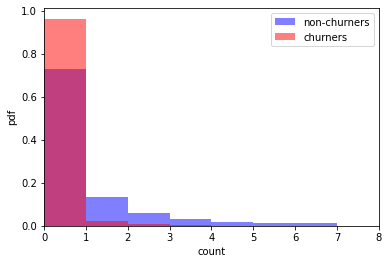

In [74]:
rng = 8
plt.hist(no_users_n_df.iloc[:, 1], bins=range(rng), density=True, color='b', alpha=0.5)
plt.hist(ch_users_n_df.iloc[:, 1], bins=range(rng), density=True, color='r', alpha=0.5)

plt.xlim(0, rng)
plt.legend(('non-churners', 'churners'))
plt.xlabel('count')
plt.ylabel('pdf')

# plt.savefig(os.path.join(save_path, 'img', 'sample_distribution_%s.png' % sett2str(settings)))

# Construct timeseries

In [75]:
if settings['method'] == 'binaryparametric':
    ts = convert_to_binary_parametric(ch_users_n_df, no_users_n_df)
elif settings['method'] == 'multiparametric':
    ts = convert_to_2d_parametric(ch_users_n_df, no_users_n_df)
elif settings['method'] == 'zscoreparametric':
    ts = convert_to_zscore(ch_users_n_df, no_users_n_df)

# Display timeseries

Text(0, 0.5, 'user ID')

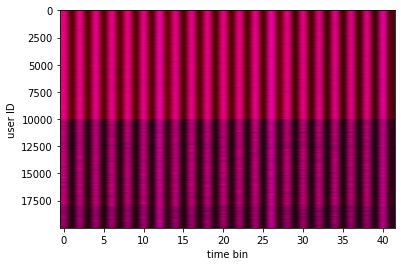

In [76]:
if settings['method'] == 'binaryparametric' or settings['method'] == 'zscoreparametric':
    plt.imshow(ts, cmap='gray', aspect='auto')
elif settings['method'] == 'multiparametric':
    dummy_ts = np.zeros((ts.shape[0], ts.shape[1], 3))
    dummy_ts[:, :, [0, 2]] = ts
    plt.imshow(dummy_ts, aspect='auto')

plt.xlabel('time bin')
plt.ylabel('user ID')

# plt.savefig(os.path.join(save_path, 'img', 'user_timebin_%s.png' % sett2str(settings)), dpi=100)

# Save timeseries

In [77]:
savemat(os.path.join(save_path, 'timeseries', 'ts_%s.mat' % sett2str(settings)), {'ts': ts})

(array([555521., 118383.,  16022., 130102., 139517., 313389.,  52322.,
             0.,      0., 354744.]),
 array([0.        , 0.09480007, 0.18960015, 0.28440022, 0.37920029,
        0.47400037, 0.56880044, 0.66360052, 0.75840059, 0.85320066,
        0.94800074]),
 <BarContainer object of 10 artists>)

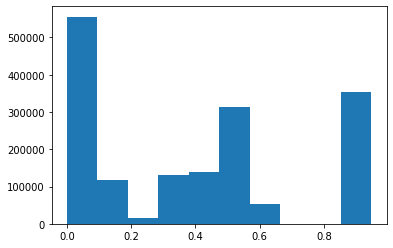

In [78]:
plt.hist(ts.reshape((-1, )), bins=10)